## Dependency

In [6]:
%matplotlib inline
from brian2 import *
import numpy as np
import math
from scipy.stats import kstest, norm
import pandas
import seaborn as sns
import statistics as stats
import sys
from IPython.display import clear_output

## Results: Random WTA

經過調參之後的結果，以下成功模擬出 gaussian bump 每次試驗因 noise 的影響而於隨機的位置出現之情況，block 1 為單次的結果圖示、block 3 為各個位置 bump 出現次數的累積，以及數次試驗中的成功率。其中，由於不一定每次都會成功出現 WTA (trivial activation 或 saturation, 詳見 parameter tuning section)，因此成功率就是在紀錄數次試驗中成功出現 WTA 的機率。

### Final Initialization

Total mean: 0.15089969376851778
Max: 0.42675407469754784
Width: 2
MAX index: 4
Total std: 0.15085782449988241
winner std: 0.1640163578279458


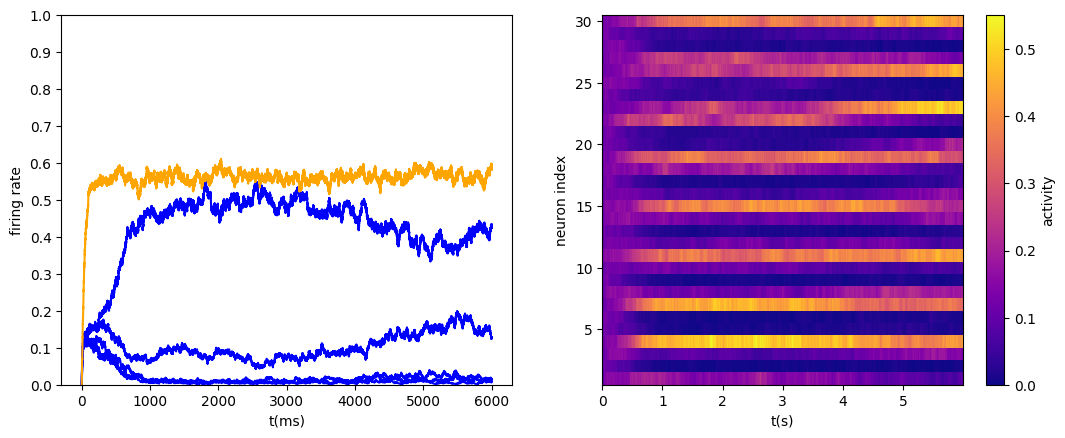

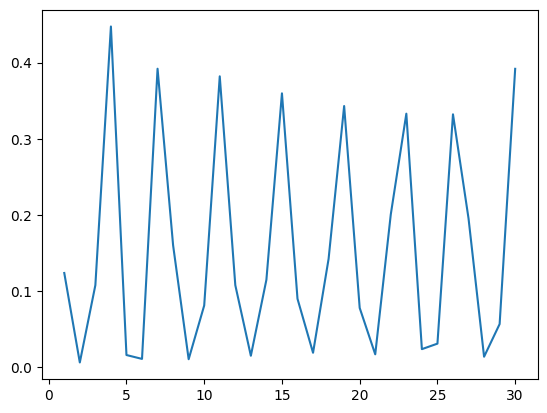

In [46]:
start_scope()


test_set=[]
control=[]
L=2 #local domain
U=L+1

#initial conditions
light=0       ###10^-8


n=31 #num of neurons
jump=2 #spacing

slope=5               
t=46*ms           
threshold=100  
mean=500
std=2000       #done

w_E=100      #354    
w_Ib=-20           
w_Iw=-5000


#simulation
eqs='''
dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
Iin : 1
Isyn : 1
theta : 1
a : 1
sigma : 1
tau : second
mu : 1
'''

G=NeuronGroup(n, eqs, method='euler');


G.r = 0.0
G.tau=t
G.Iin=0
G.Iin[15]=light
G.theta=threshold
G.a=slope
G.mu=mean
G.sigma=std


S = Synapses(G, G, '''
             w : 1 # synaptic weight
             Isyn_post = w * r_pre : 1 (summed)
             ''')

I=[];J=[]
for syn in range(1,n):
    I.append(syn)
    J.append(0)
for syn in range(1,n):
    I.append(0)
    J.append(syn)

for syn in range(1,n):
    if syn < (n-1):
        I.append(syn)
        J.append(syn+1)
    else:
        I.append(syn)
        J.append(1)
if n>3:
    for syn in range(n-1,0,-1):
        if syn>1:
            I.append(syn)
            J.append(syn-1)
        else:
            I.append(syn)
            J.append(n-1)
if n>4:
    for syn in range(1,n):
        if (syn+jump) <= (n-1):
            I.append(syn)
            J.append(syn+jump)
        else:
            I.append(syn)
            J.append(syn-(n-1-jump))
if n>5:
    for syn in range(n-1,0,-1):
        if syn>jump:
            I.append(syn)
            J.append(syn-2)
        else:
            I.append(syn)
            J.append(syn+(n-1-jump))



S.connect(i=I,j=J)

S.w=w_Iw
for syn in np.arange(n-1):
    S.w[syn]=w_Ib

for syn in np.arange(n-1, 2*n-2):
    S.w[syn]=w_E


M = StateMonitor(G, 'r', record=True)

run(6000*ms)

figure(figsize=(12.8,4.8))
subplot(121)
MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1

for i in range(1,31):
    if (MAX-i)<=0:
        if (np.mean(M.r[(MAX-i)+30][20000:])/np.mean(M.r[MAX][20000:]))<0.6:
            width=(i*2)
            break
    else:
        if (np.mean(M.r[MAX-i][20000:])/np.mean(M.r[MAX][20000:]))<0.6:
            width=(i*2)
            break 

#Winners
winner_id=[]
if MAX<=L:
    for i in range(MAX-L,MAX+U):
        if i <=0:
            plot(M.t/ms, M.r[i+(n-1)], color='blue')
            winner_id.append(i+(n-1))
            
        else:
            plot(M.t/ms, M.r[i%(n-1)], color='blue')
            winner_id.append(i%(n-1))
            

else:
    for i in range(MAX-L,MAX+U):
        if i == 31:
            plot(M.t/ms, M.r[1], color='blue')
            winner_id.append(1)
            
        else:
            plot(M.t/ms, M.r[i%n], color='blue')
            winner_id.append(i%n)
            

pending=[np.mean(M.r[i][27500:]) for i in winner_id]



plot(M.t/ms, M.r[0], color='orange')
ylim(0,1)
yticks(np.arange(0,1.1,0.1))
xlabel('t(ms)')
ylabel('firing rate')

subplot(122)
neuron_index=range(1,n)
pc=pcolormesh(M.t,neuron_index,M.r[1:31],cmap='plasma', shading='auto');
cbar = colorbar(pc)  # 'pc' is the return value of the pcolormesh call
cbar.set_label('activity')
xlabel('t(s)')
ylabel('neuron index')

print(f'Total mean: {np.mean(M.r[1:n])}')
#print(f'winner mean: {np.mean(test_set)}')
#print(f'loser mean: {np.mean(control)}')
print(f'Max: {np.mean(M.r[MAX])}')
print(f'Width: {width}')

#Distribution check
figure(figsize=(6.4,4.8))
plot(range(1,31),np.mean(M.r[1:,20000:], axis=1));
print(f'MAX index: {MAX}')
print(f'Total std: {np.std(M.r[1:n, 27500:])}')
print(f'winner std: {np.std(pending)}');

# Parameter Tuning

## Explicit

light=0     


n=31 
jump=2 

slope=5               
t=46*ms           
threshold=100  
mean=500

std=2000      

w_E=100       
w_Ib=-20           
w_Iw=-5000

### 1. time const

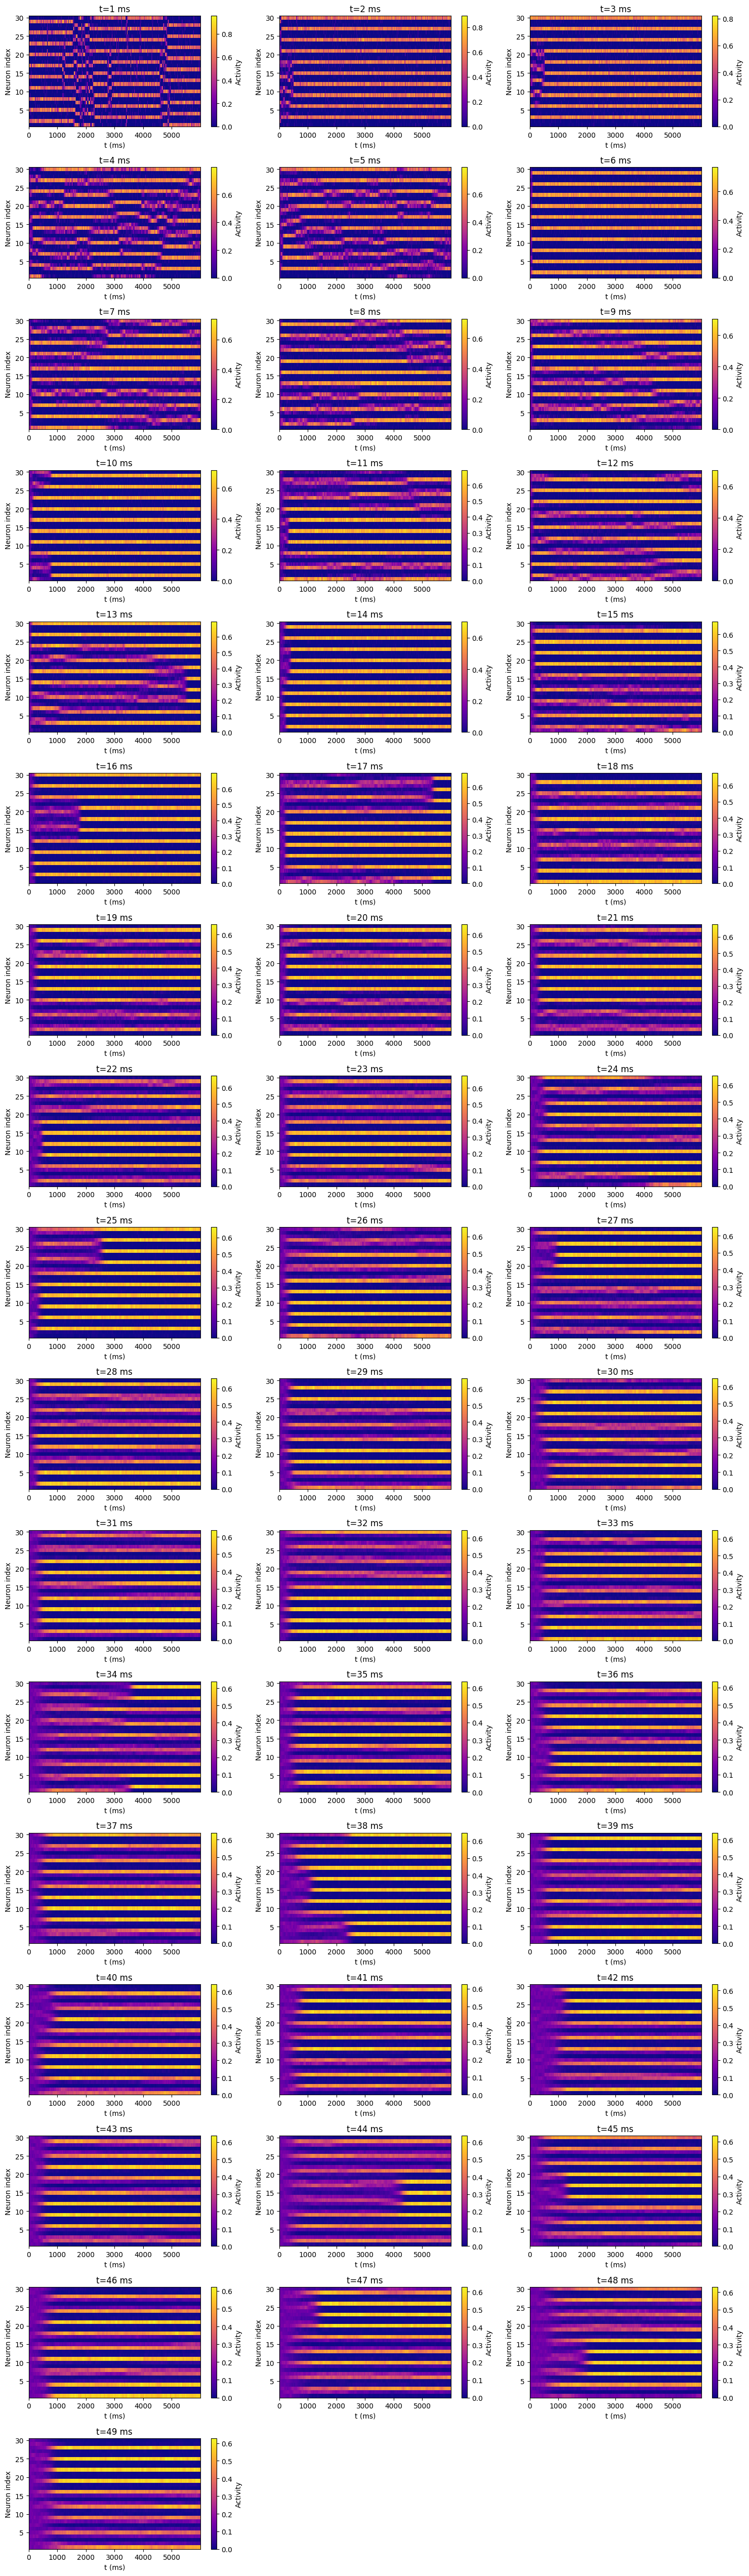

In [20]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(1, 50)

for T in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=T*ms           
    threshold=100  
    mean=500
    std=2000      #done

    w_E=100      #354    
    w_Ib=-20           
    w_Iw=-5000


    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(6000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"t={acc[i]} ms")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

$t:~noisy \rightarrow more~defined$

### 2. w_Iw

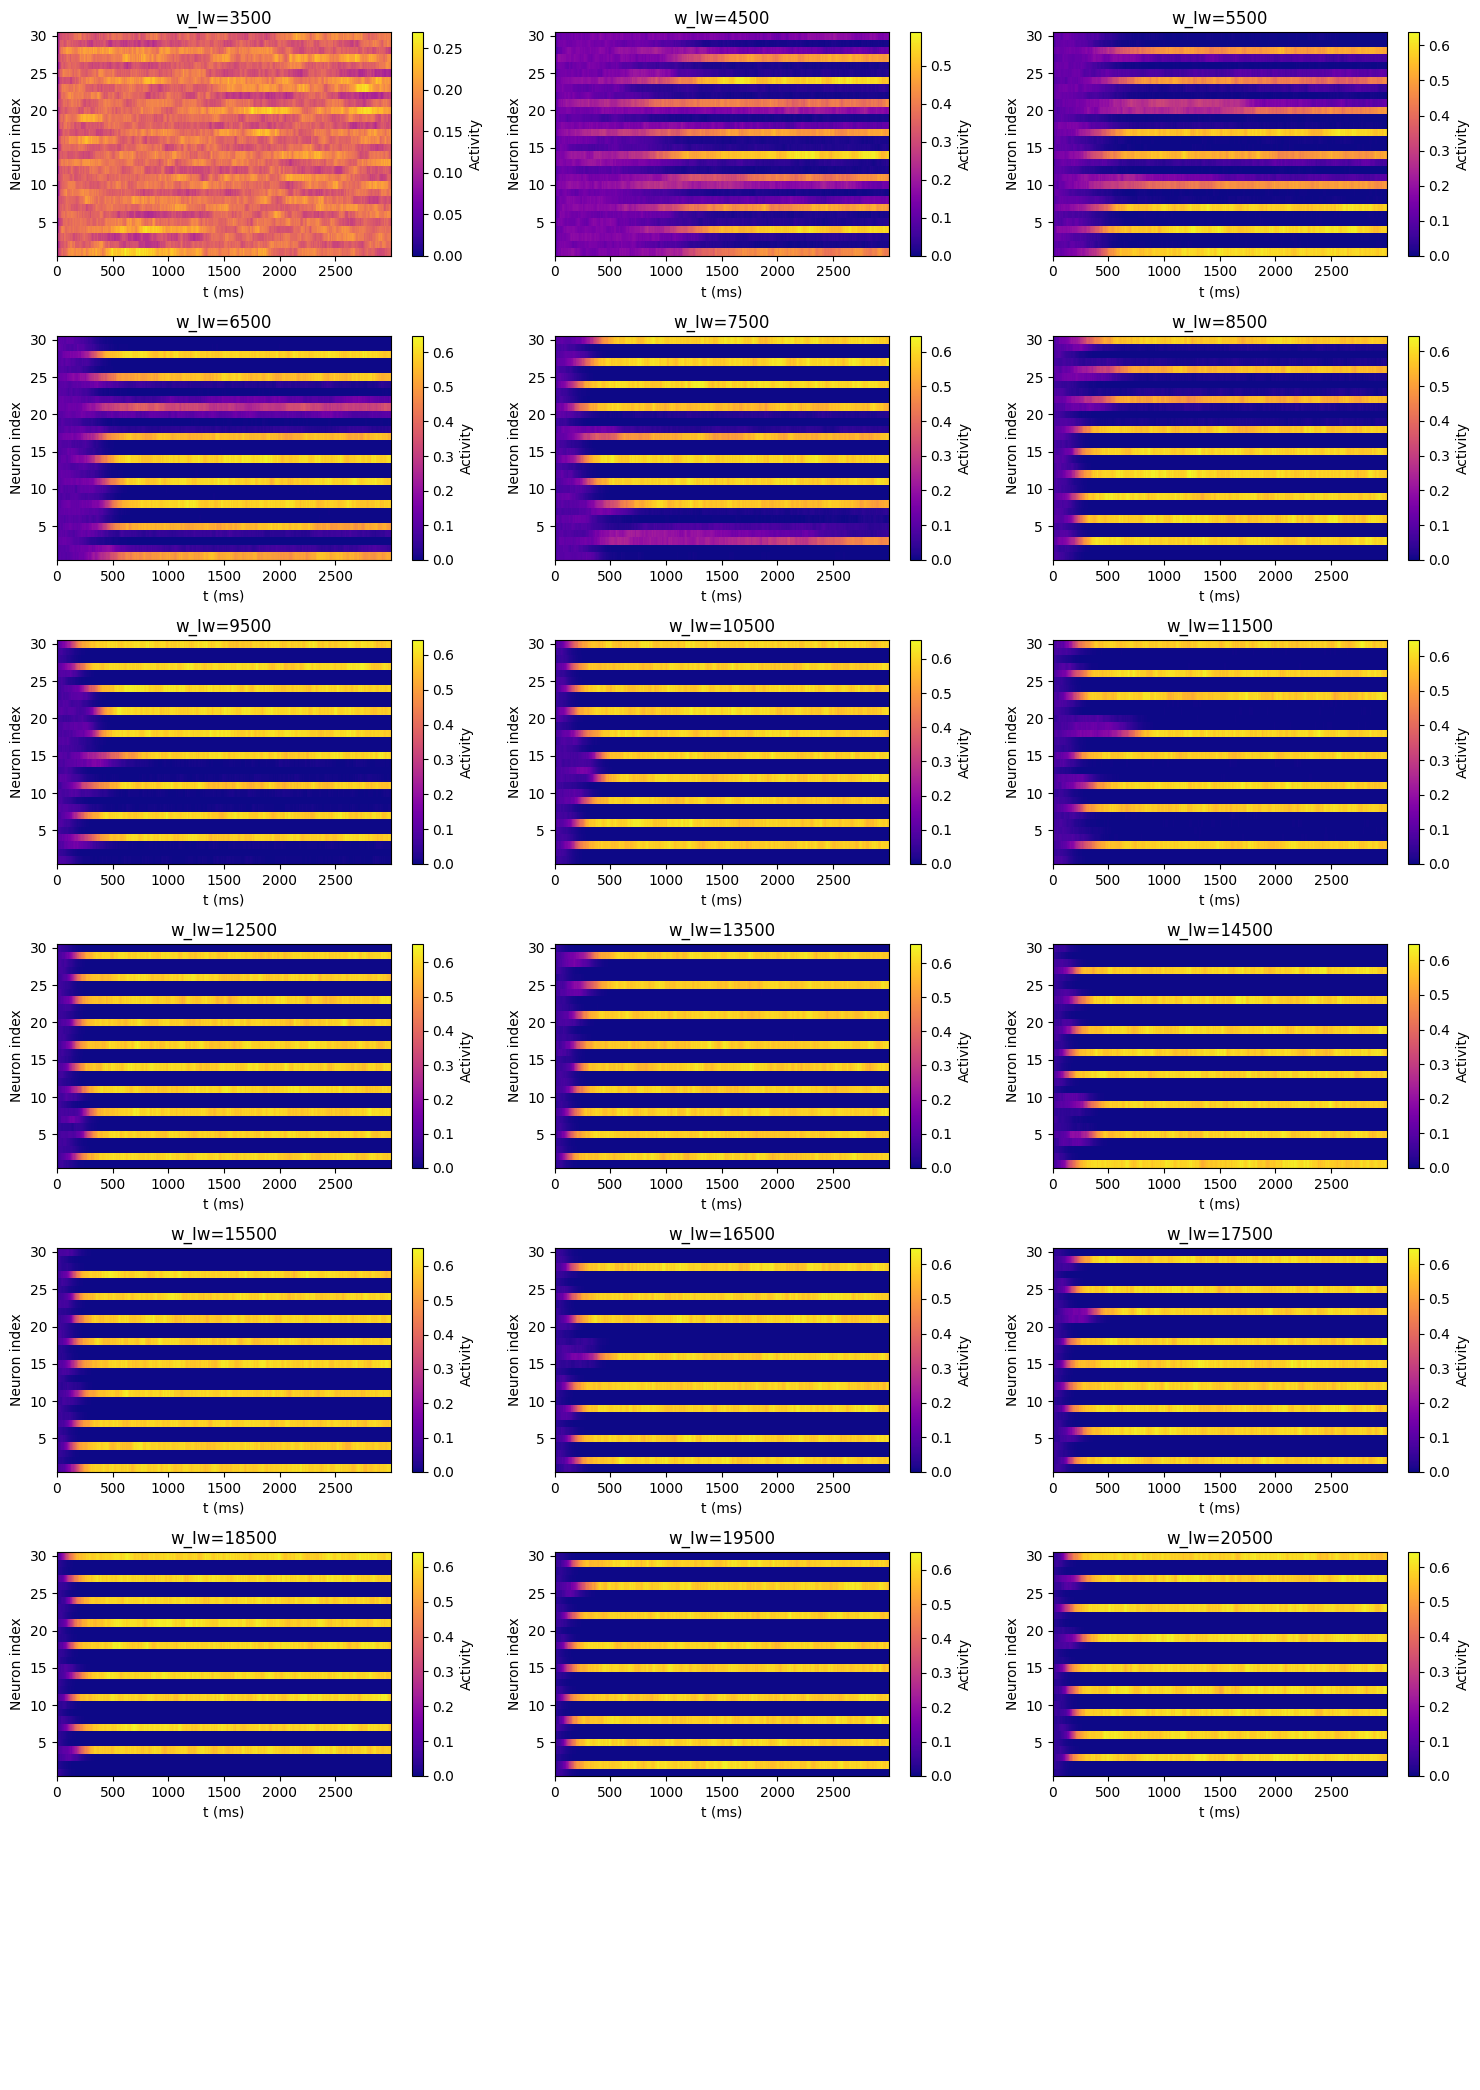

In [7]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(3500, 21000, 1000)

for WIW in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=100  
    mean=500
    std=2000       #done

    w_E=100      #354    
    w_Ib=-20           
    w_Iw=-WIW



    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(3000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"w_Iw={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

$wIw:~noisy \rightarrow more~defined$

### 3. w_Ib

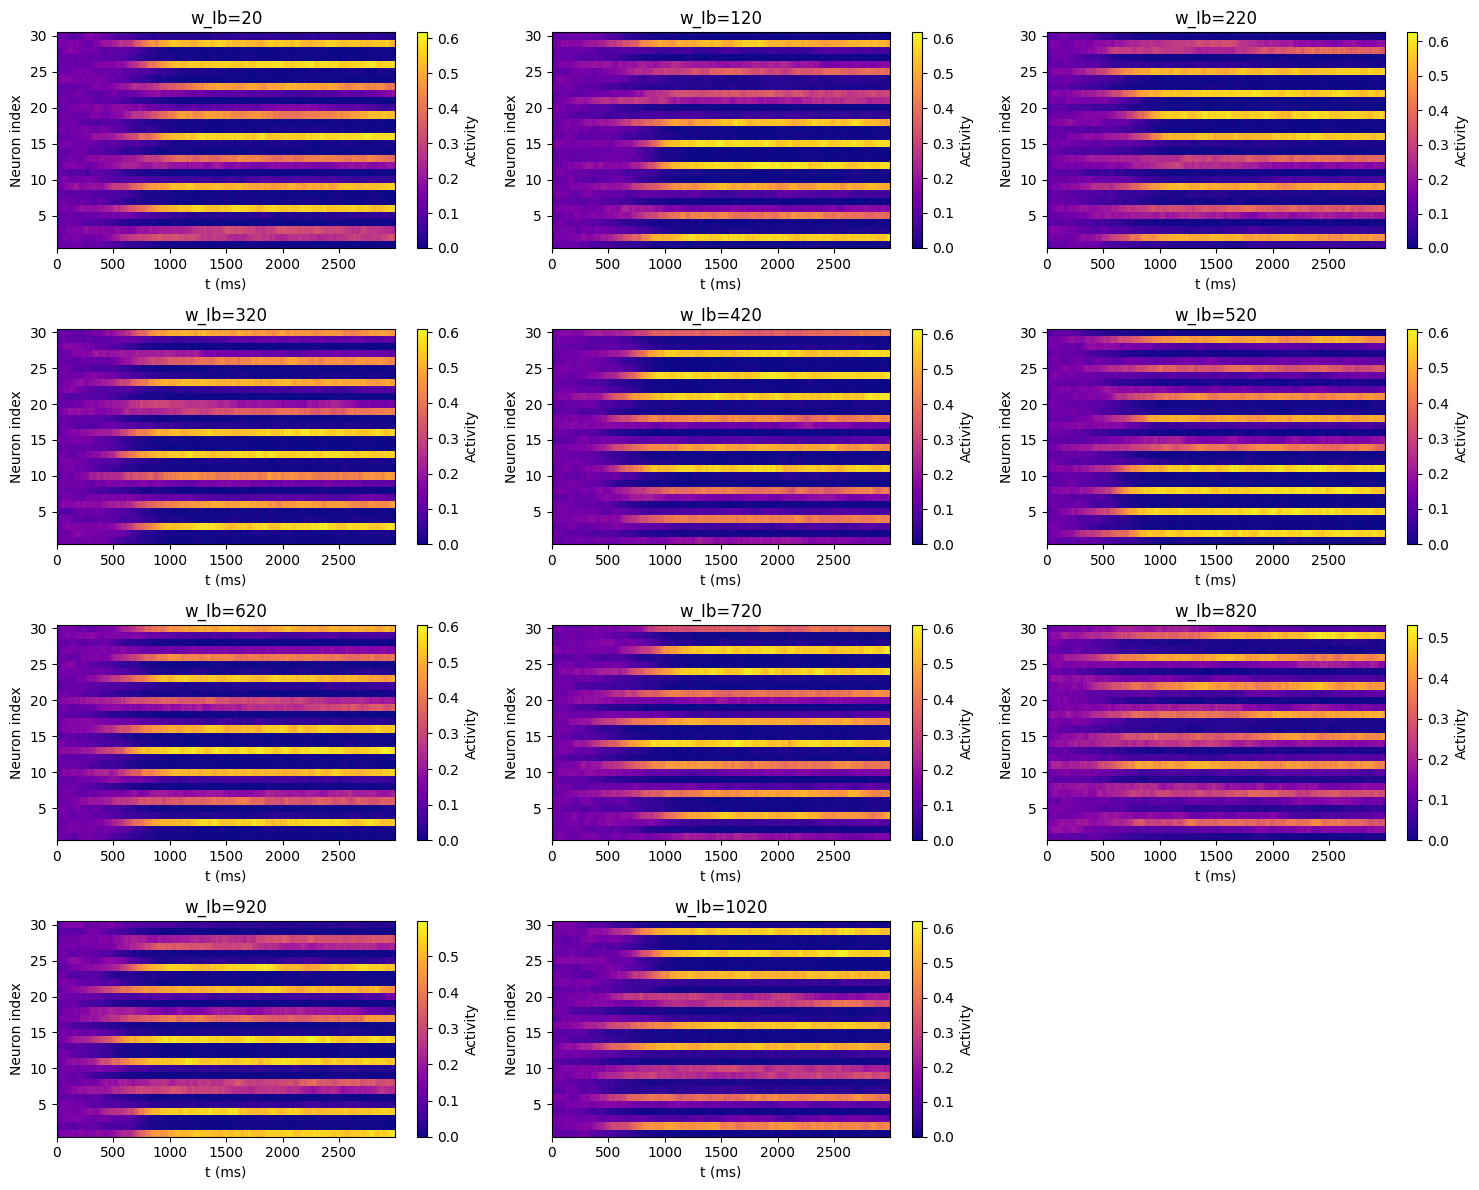

In [13]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(20, 1120, 100)

for WIB in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=100  
    mean=500
    std=2000       #done

    w_E=100      #354    
    w_Ib=-WIB           
    w_Iw=-5000



    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(3000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"w_Ib={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

$wIb:~roughly~the~same$

### 4. w_E

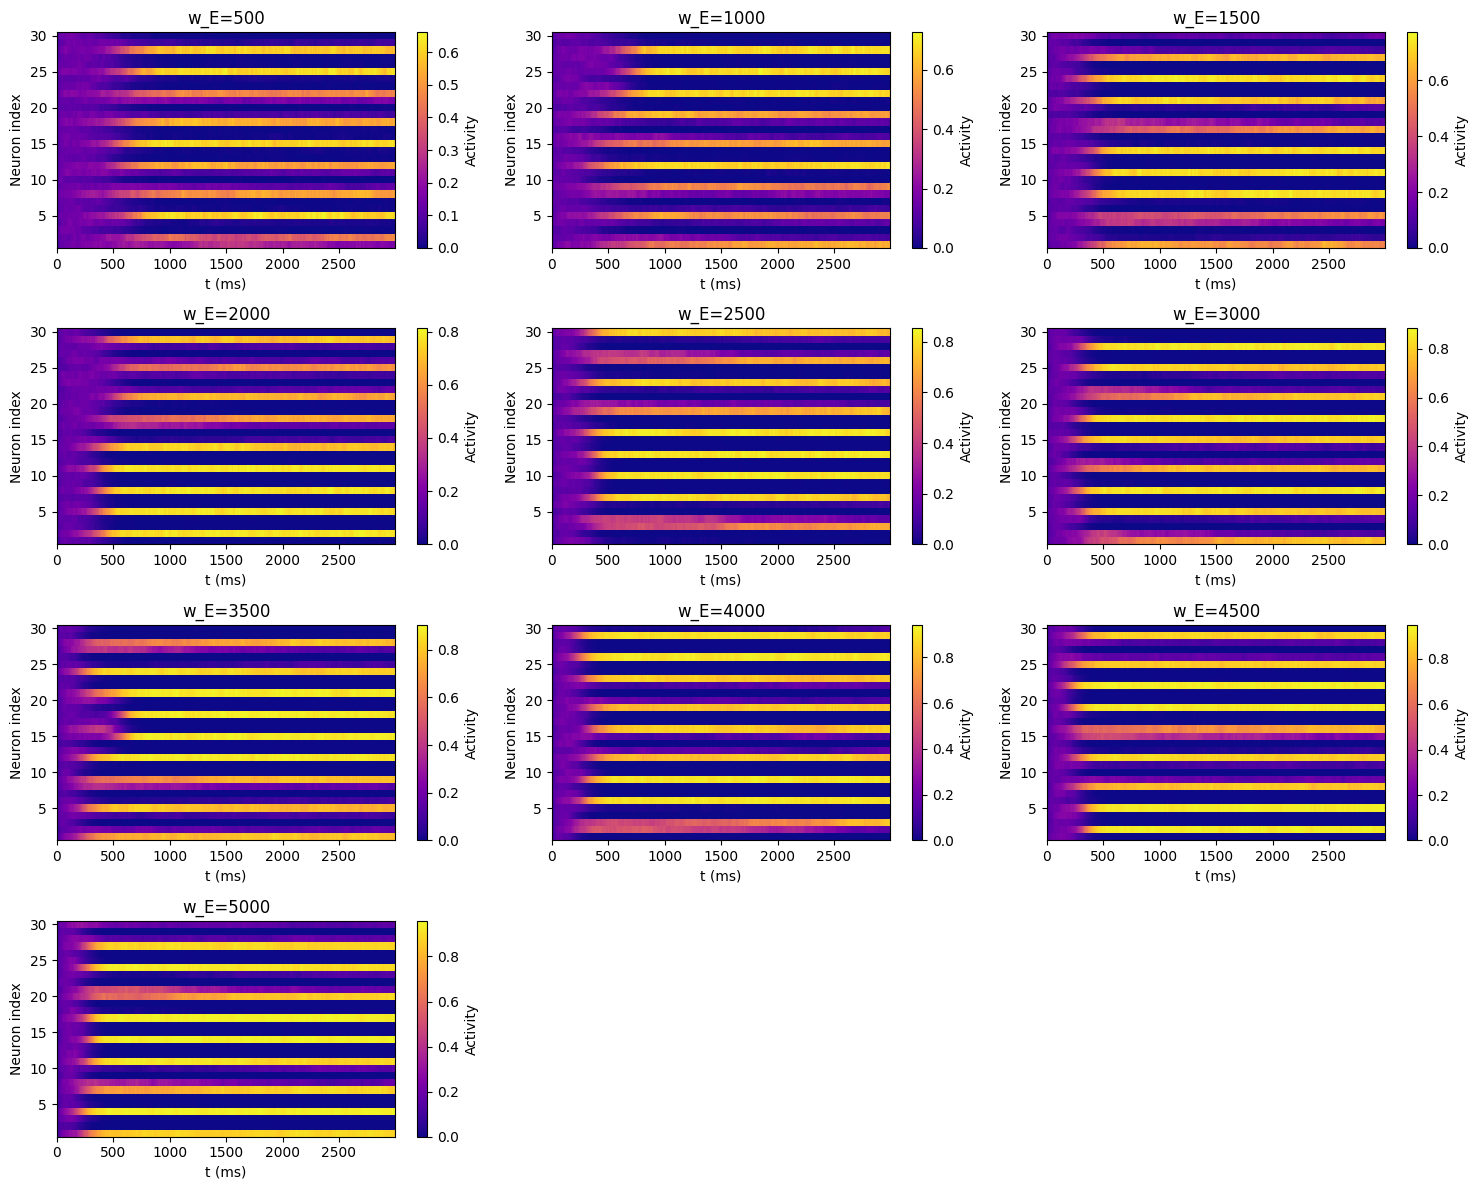

In [26]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(500, 5500, 500)

for WE in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=100  
    mean=500
    std=2000       #done

    w_E=WE      #354    
    w_Ib=-20           
    w_Iw=-5000



    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(3000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"w_E={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

### 5. mean

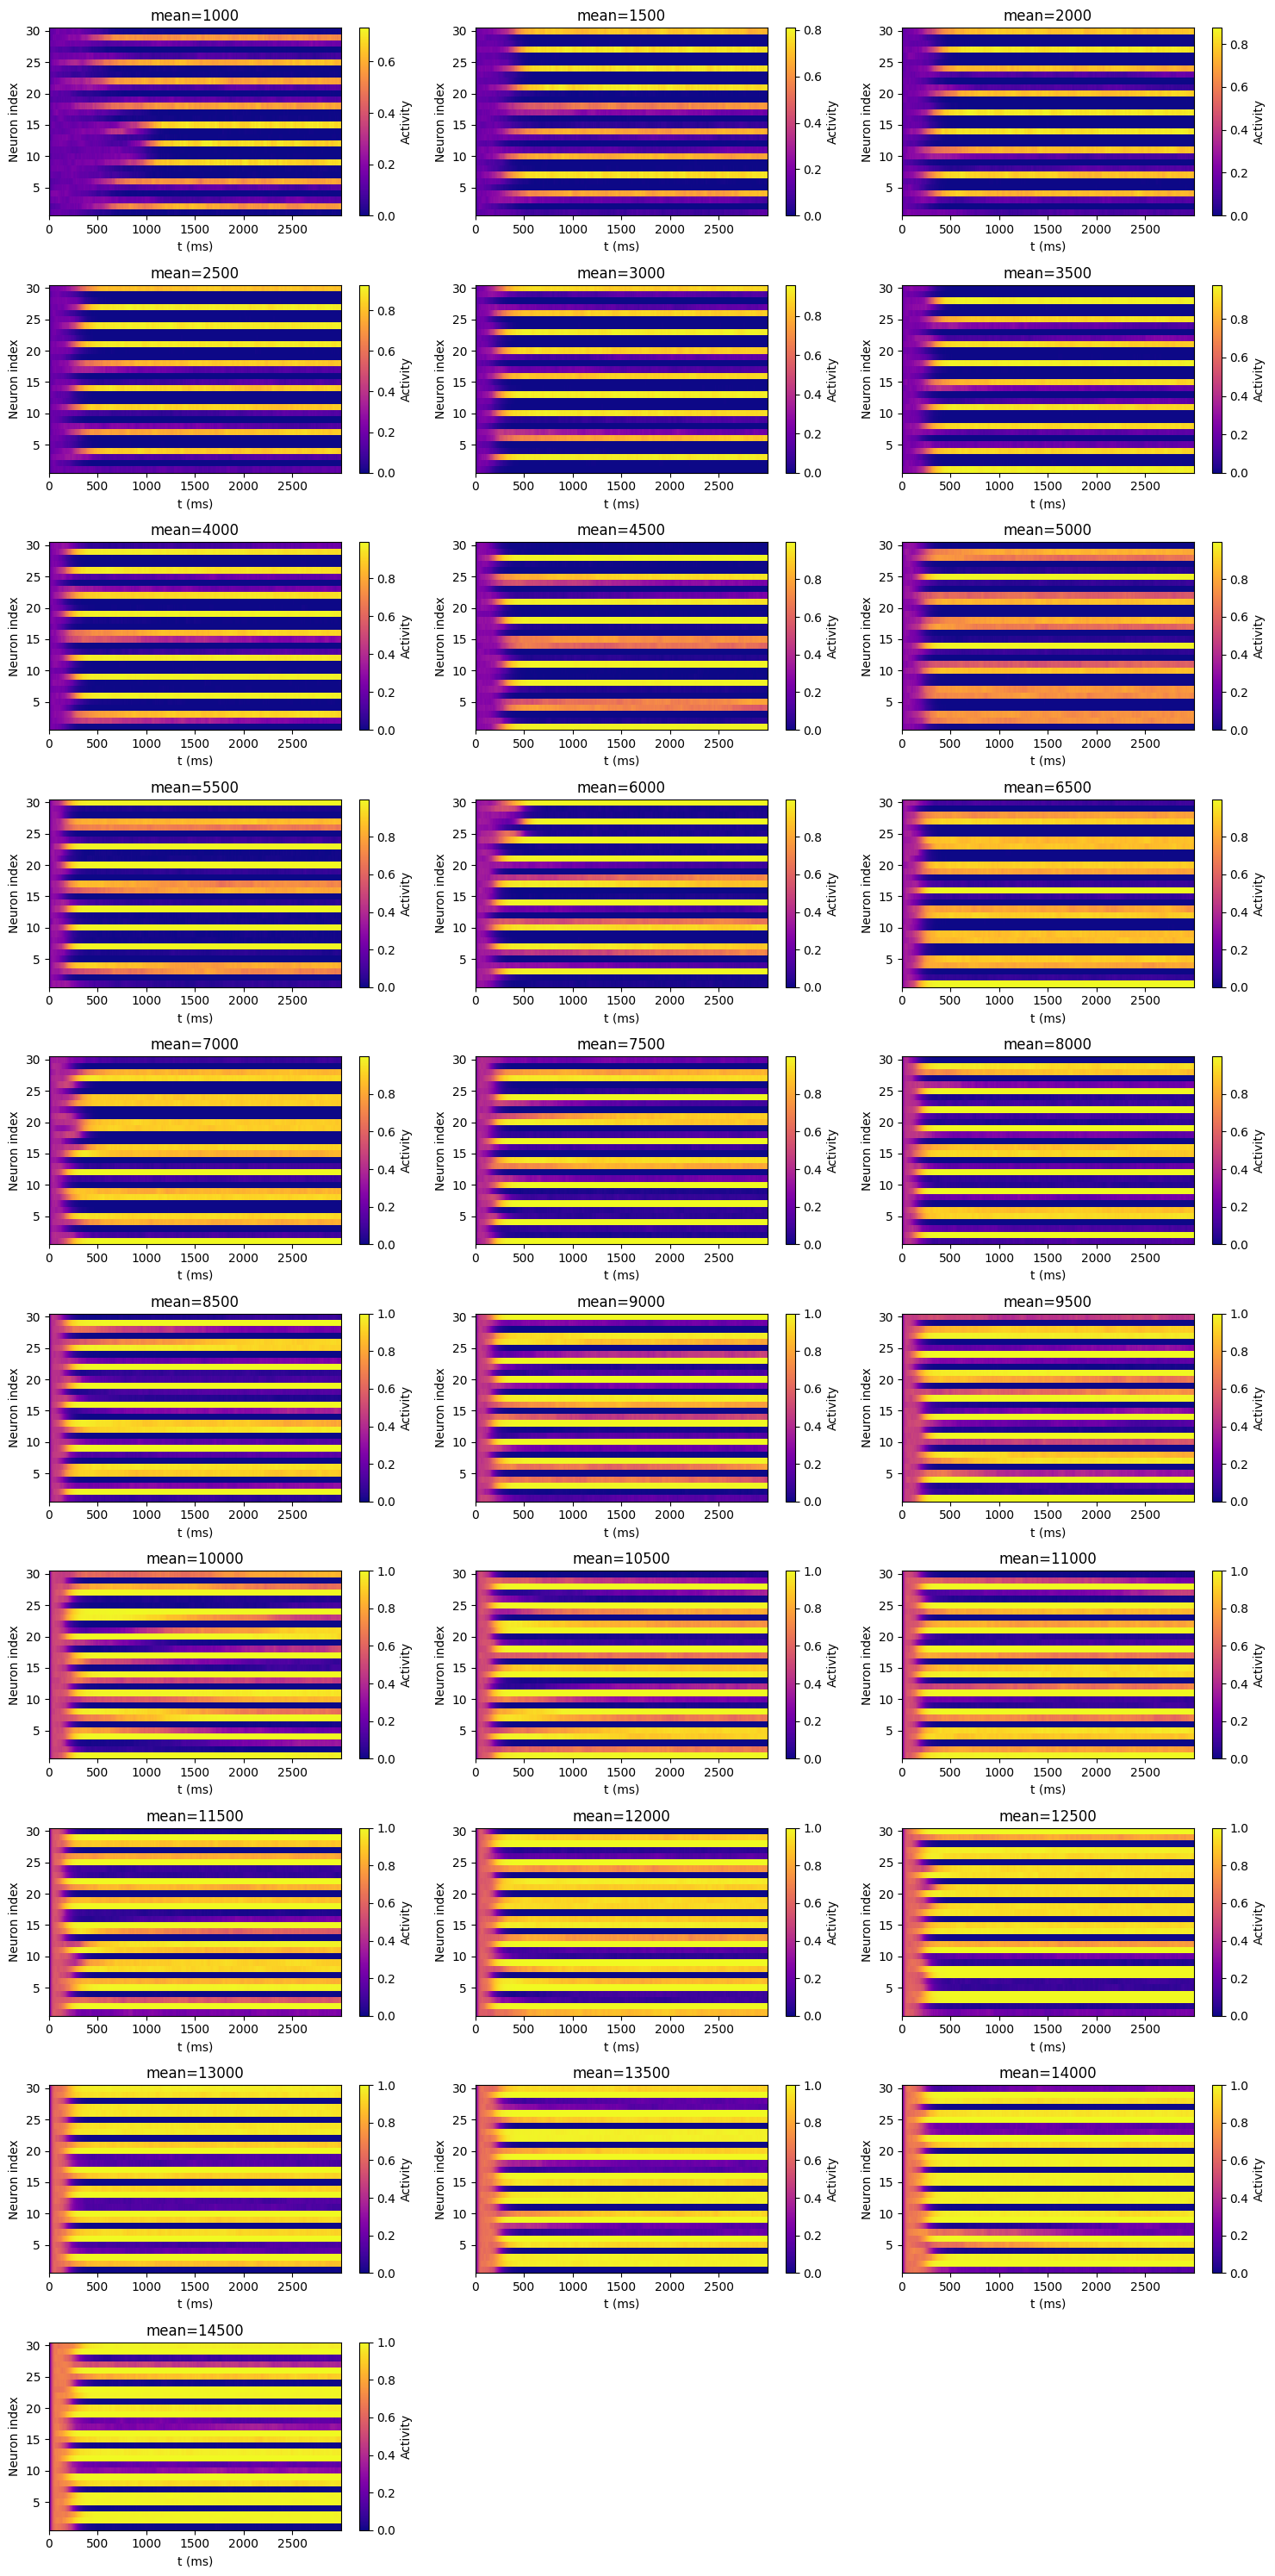

In [21]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(1000, 15000, 500)

for MN in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=100  
    mean=MN
    std=2000       #done

    w_E=100      #354    
    w_Ib=-20           
    w_Iw=-5000


    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(3000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"mean={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

### 6. std

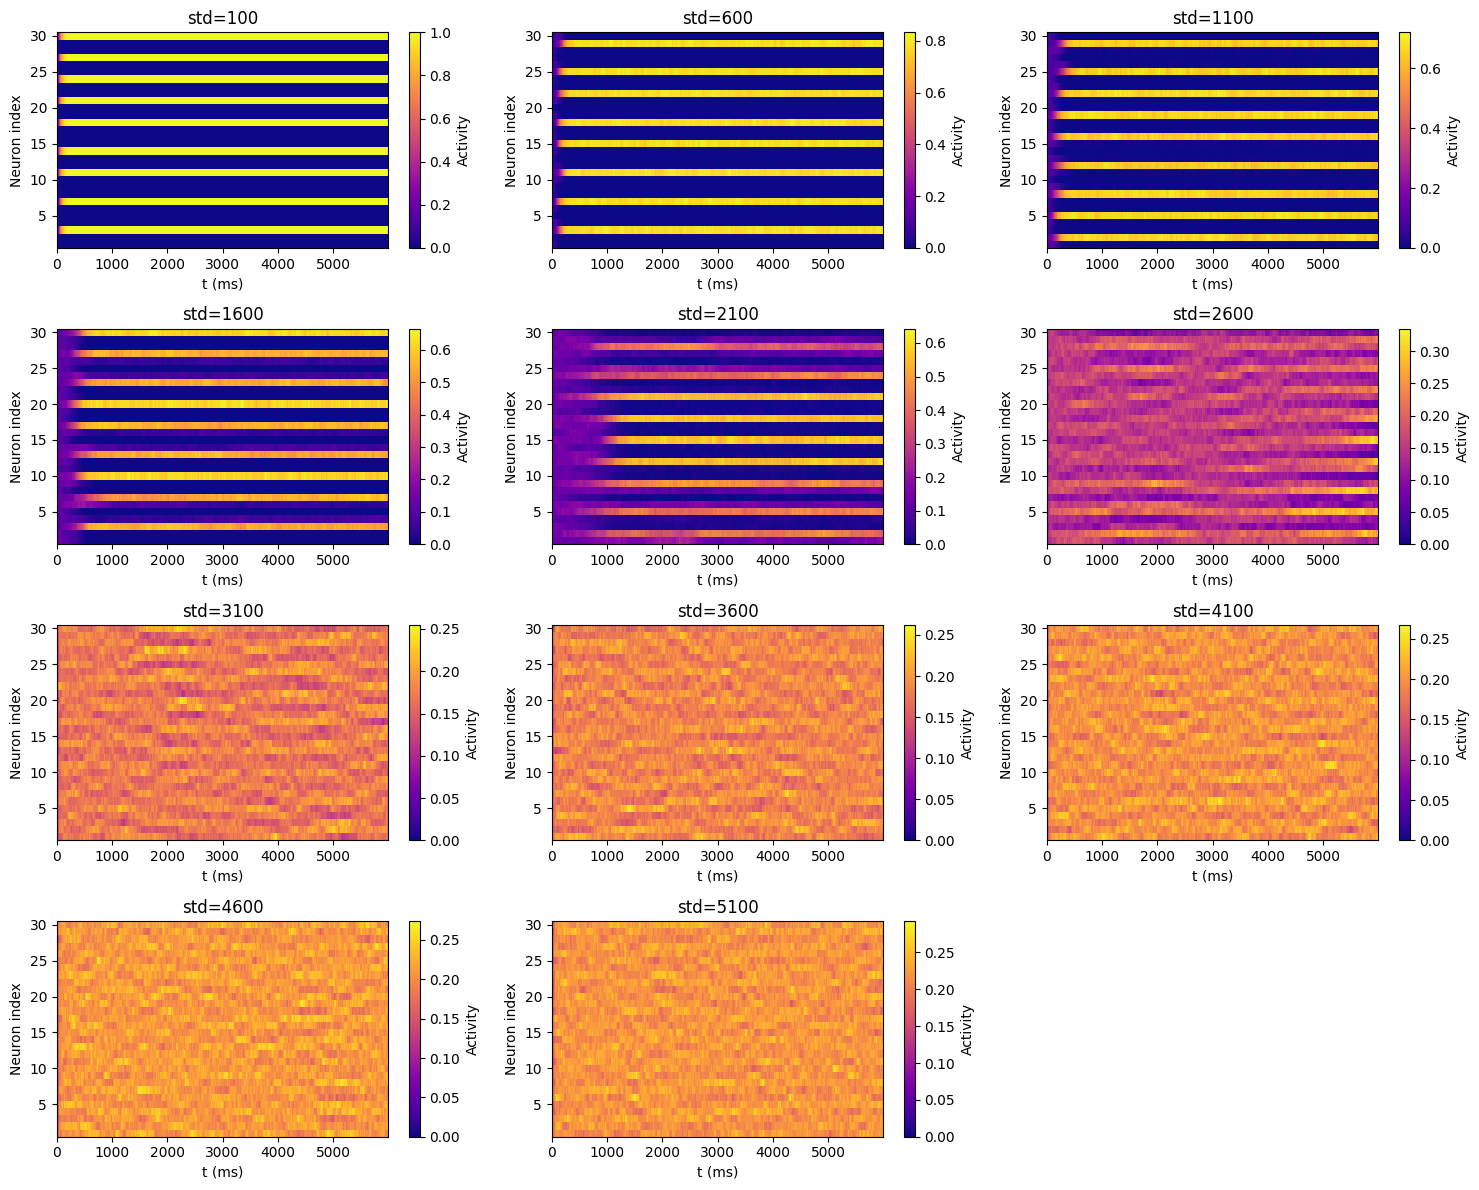

In [30]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(100, 5600,500)

for STD in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=100  
    mean=500
    std=STD      #done

    w_E=100      #354    
    w_Ib=-20           
    w_Iw=-5000


    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(6000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"std={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

### 7. Threshold

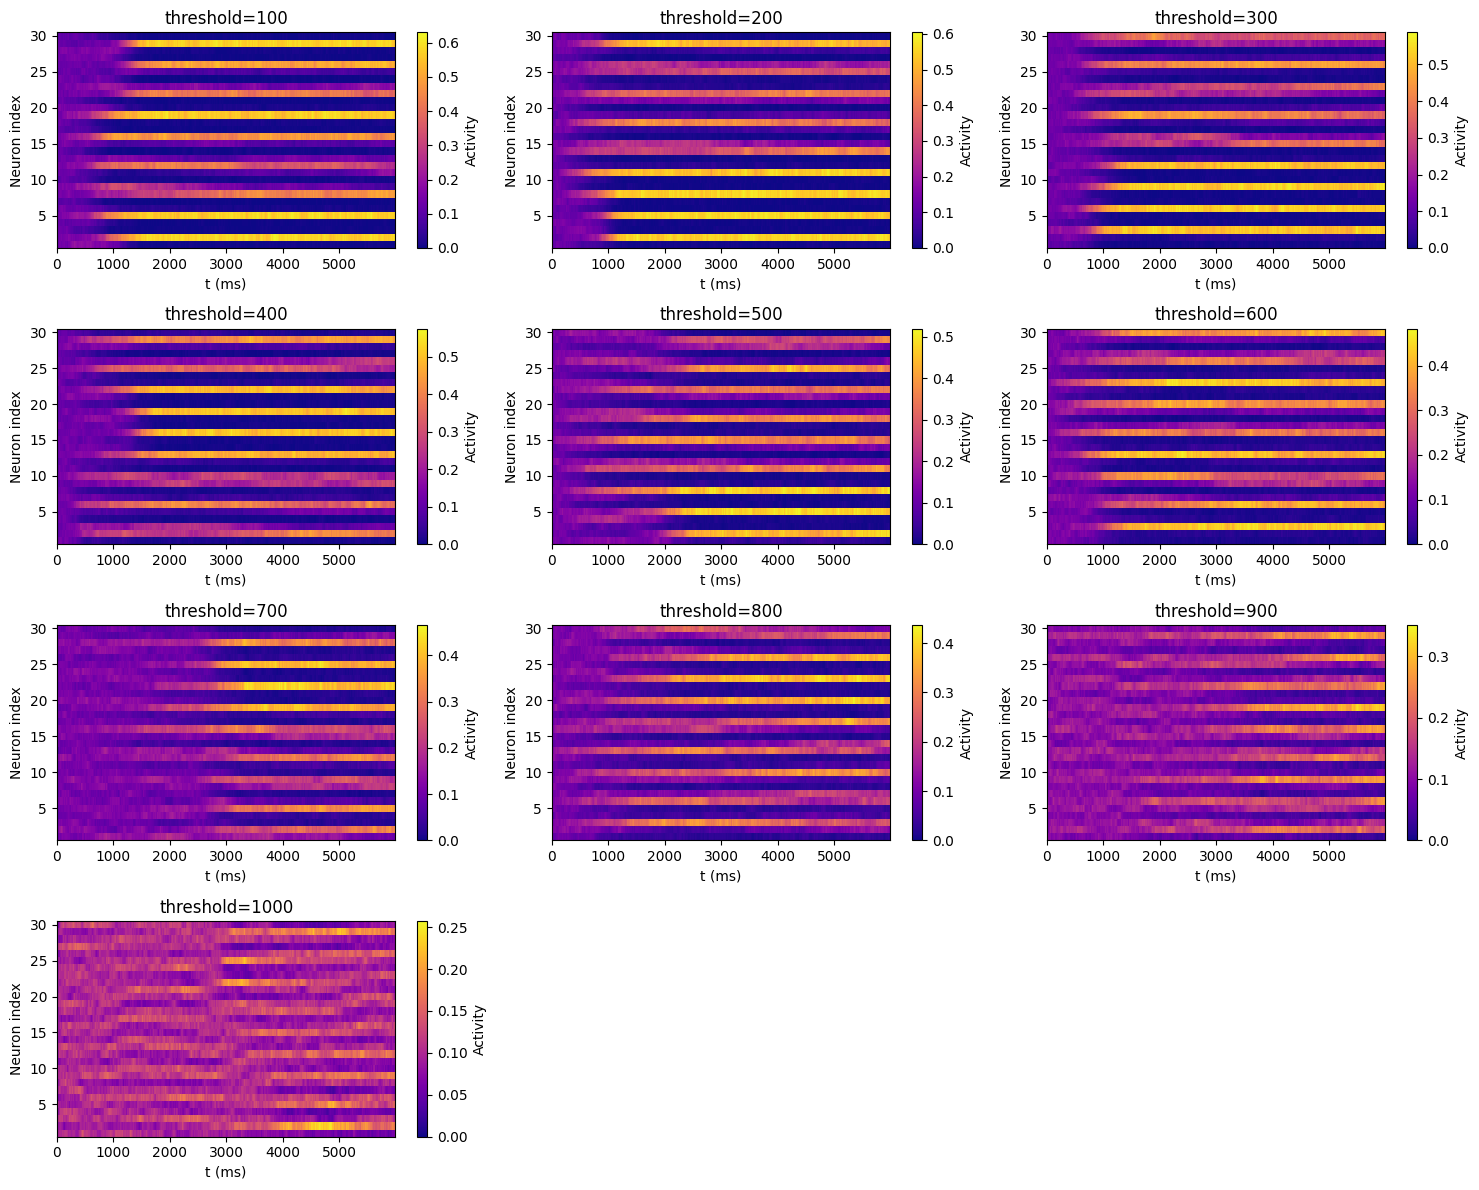

In [28]:
start_scope()
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=1
all_activity = []
acc=np.arange(100, 1100,100)

for TH in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    
    #initial conditions
    light=0       ###10^-8


    n=31 #num of neurons
    jump=2 #spacing

    slope=5               
    t=46*ms           
    threshold=TH  
    mean=500
    std=2000      #done

    w_E=100      #354    
    w_Ib=-20           
    w_Iw=-5000


    #simulation
    eqs='''
    dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
    Iin : 1
    Isyn : 1
    theta : 1
    a : 1
    sigma : 1
    tau : second
    mu : 1
    '''

    G=NeuronGroup(n, eqs, method='euler');


    G.r = 0.0
    G.tau=t
    G.Iin=0
    G.theta=threshold
    G.a=slope
    G.mu=mean
    G.sigma=std


    S = Synapses(G, G, '''
                w : 1 # synaptic weight
                Isyn_post = w * r_pre : 1 (summed)
                ''')

    I=[];J=[]
    for syn in range(1,n):
        I.append(syn)
        J.append(0)
    for syn in range(1,n):
        I.append(0)
        J.append(syn)

    for syn in range(1,n):
        if syn < (n-1):
            I.append(syn)
            J.append(syn+1)
        else:
            I.append(syn)
            J.append(1)
    if n>3:
        for syn in range(n-1,0,-1):
            if syn>1:
                I.append(syn)
                J.append(syn-1)
            else:
                I.append(syn)
                J.append(n-1)
    if n>4:
        for syn in range(1,n):
            if (syn+jump) <= (n-1):
                I.append(syn)
                J.append(syn+jump)
            else:
                I.append(syn)
                J.append(syn-(n-1-jump))
    if n>5:
        for syn in range(n-1,0,-1):
            if syn>jump:
                I.append(syn)
                J.append(syn-2)
            else:
                I.append(syn)
                J.append(syn+(n-1-jump))



    S.connect(i=I,j=J)

    S.w=w_Iw
    for syn in np.arange(n-1):
        S.w[syn]=w_Ib

    for syn in np.arange(n-1, 2*n-2):
        S.w[syn]=w_E



    M = StateMonitor(G, 'r', record=True)

    run(6000*ms)
    
    all_activity.append(M.r[1:, :])

    print(f'Iter {Iter}, {round(Iter*100/len(acc))}%')
    clear_output(wait=True)

    Iter+=1
# After loop: Create a grid of plots
num_iterations = len(all_activity)
cols = 3
rows = (num_iterations// cols)+1  # Calculate rows dynamically

fig, axes = subplots(rows, cols, figsize=(15, rows * 3))

# Flatten axes for easy iteration (if rows and cols > 1)
axes = axes.flatten()

for i, activity in enumerate(all_activity):
    ax = axes[i]
    pc = ax.pcolormesh(M.t / ms, np.arange(1, n), activity, cmap='plasma', shading='auto')
    ax.set_title(f"threshold={acc[i]}")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("Neuron index")
    fig.colorbar(pc, ax=ax, label="Activity")

    print(f'plot: {round((i+1)*100/len(all_activity))}%')
    clear_output(wait=True)

# Hide unused subplots (if any)
for j in range(len(all_activity), len(axes)):
    axes[j].axis('off')


tight_layout()
show();

## Implicit


以下分別針對各個參數進行調整，再畫出 target function 隨參數的變化，以及模擬結果的比例統計 (trivial, success, explosion)。

<span style="font-size: 11.5px;">
trivial: 神經元 FR 躺平 <br>
success: 成功出現 WTA dynamic<br>
explosion: 神經元 FR 衝到頂
</span>

### 1. threshold Tuning


Iter 11/Rep 10, 100%


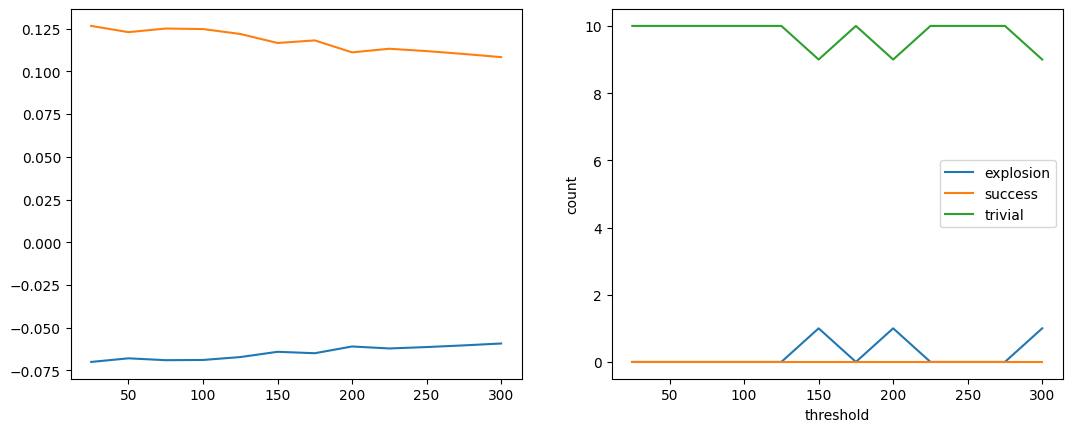

In [15]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
ALLS=[]
GAPS=[]
REP=10
acc=np.arange(25, 325, 25)

for TH in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    mean_all=0
    mean_gap=0
    for rep in range(REP):
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=46*ms           
        threshold=TH  
        mean=500
        std=2000       #done

        w_E=100      #354    
        w_Ib=-20           
        w_Iw=-5000


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Iw
        for syn in np.arange(n-1):
            S.w[syn]=w_Ib

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_E



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
    
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    winner_id.append(i+(n-1))
                else:
                    winner_id.append(i%(n-1))
        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    winner_id.append(1)
                else:
                    winner_id.append(i%n)
              
        winner_mean=np.mean([np.mean(M.r[i, 27500:]) for i in winner_id])
        loser_mean=np.mean([np.mean(M.r[i, 27500:]) for i in range(1,n) if i not in winner_id])

        if np.std(M.r[1:n, 27500:])<=0.15:
            ex+=1
        elif np.mean(M.r[1:n])<=0.2:
            tri+=1
        elif np.std(M.r[1:n, 27500:])>0.15 and np.std(pending)<0.15: 
            suc+=1
        mean_all+=np.mean(M.r[:, 27500:])
        mean_gap+=(winner_mean-loser_mean) 

        if repetition==(REP-1):
            ALLS.append(mean_all/REP)
            GAPS.append(mean_gap/REP)
            

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}, {round((Iter*REP+repetition)*100/(REP*len(acc)))}%')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1



figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, GAPS)
plot(acc, (2-np.array(ALLS))*abs(np.array(GAPS)))

subplot(122)
plot(acc, explosion);
plot(acc, success);
plot(acc, trivial);
xlabel('threshold')
ylabel('count')

legend(['explosion','success','trivial']);

show();



Iter 19/Rep 20, 100%


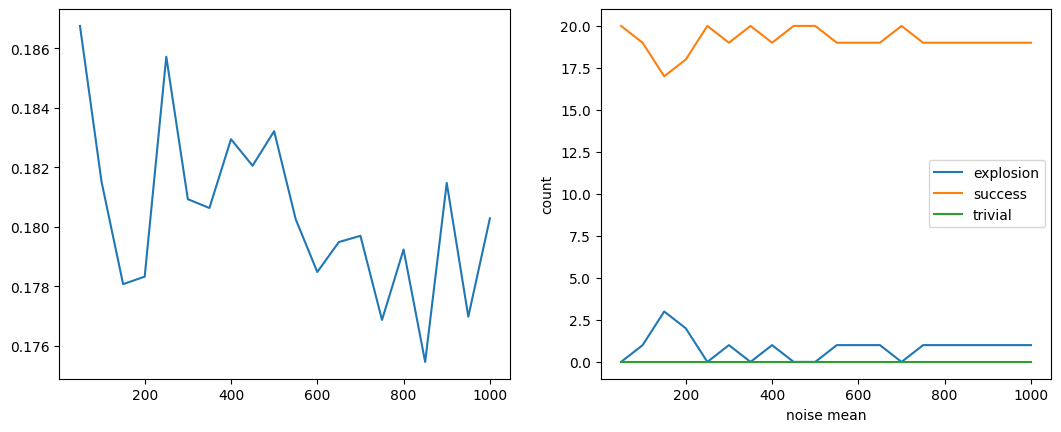

In [83]:
start_scope()
reptargetf=[]
targetf=[]
mx=[]
mx_nei=[]
L=2 #local domain
U=L+1
Iter=0

#Rep test
explosion=[]
success=[]
trivial=[]
global_std=[]
REP=20
acc=np.arange(50, 1050, 50)

for WIB in acc:
    ex=0
    suc=0
    tri=0
    repetition=0
    ind_std=[]
    for rep in range(REP):
        test_set=[]
        control=[]  
        #initial conditions
        light=0       ###10^-8


        n=31 #num of neurons
        jump=2 #spacing

        slope=5               
        t=46*ms           
        threshold=100  
        mean=500
        std=2000       #done

        w_E=100      #354    
        w_Ib=-WIB           
        w_Iw=-5000       #284 


        #simulation
        eqs='''
        dr/dt = ( - r + 1/(1+exp(-a*(Isyn+Iin-theta+mu+sigma*randn())))) / tau : 1
        Iin : 1
        Isyn : 1
        theta : 1
        a : 1
        sigma : 1
        tau : second
        mu : 1
        '''

        G=NeuronGroup(n, eqs, method='euler');


        G.r = 0.0
        G.tau=t
        G.Iin=0
        G.theta=threshold
        G.a=slope
        G.mu=mean
        G.sigma=std


        S = Synapses(G, G, '''
                    w : 1 # synaptic weight
                    Isyn_post = w * r_pre : 1 (summed)
                    ''')

        I=[];J=[]
        for syn in range(1,n):
            I.append(syn)
            J.append(0)
        for syn in range(1,n):
            I.append(0)
            J.append(syn)

        for syn in range(1,n):
            if syn < (n-1):
                I.append(syn)
                J.append(syn+1)
            else:
                I.append(syn)
                J.append(1)
        if n>3:
            for syn in range(n-1,0,-1):
                if syn>1:
                    I.append(syn)
                    J.append(syn-1)
                else:
                    I.append(syn)
                    J.append(n-1)
        if n>4:
            for syn in range(1,n):
                if (syn+jump) <= (n-1):
                    I.append(syn)
                    J.append(syn+jump)
                else:
                    I.append(syn)
                    J.append(syn-(n-1-jump))
        if n>5:
            for syn in range(n-1,0,-1):
                if syn>jump:
                    I.append(syn)
                    J.append(syn-2)
                else:
                    I.append(syn)
                    J.append(syn+(n-1-jump))



        S.connect(i=I,j=J)

        S.w=w_Iw
        for syn in np.arange(n-1):
            S.w[syn]=w_Ib

        for syn in np.arange(n-1, 2*n-2):
            S.w[syn]=w_E



        M = StateMonitor(G, 'r', record=True)

        run(3000*ms)

        MAX=np.argmax(np.mean(M.r[1:31],axis=1))+1
        #mx.append(np.mean(M.r[MAX]))
        

        if np.std(M.r[1:n])<=0.15:
            ex+=1
        elif np.std(M.r[1:n])<=0.15 and np.mean(M.r[1:n])<=0.2:
            tri+=1
        elif np.std(M.r[1:n])>0.15: 
            suc+=1

        
        #Winners
        winner_id=[]
        if MAX<=L:
            for i in range(MAX-L,MAX+U):
                if i <=0:
                    #plot(M.t/ms, M.r[i+(n-1)], color='green')
                    winner_id.append(i+(n-1))
                    test_set.append(np.mean( M.r[i+(n-1)]))
                else:
                    #plot(M.t/ms, M.r[i%(n-1)], color='green')
                    winner_id.append(i%(n-1))
                    test_set.append(np.mean( M.r[i%(n-1)]))

        else:
            for i in range(MAX-L,MAX+U):
                if i == 31:
                    #plot(M.t/ms, M.r[1], color='green')
                    winner_id.append(1)
                    test_set.append(np.mean( M.r[i%n]))
                else:
                    #plot(M.t/ms, M.r[i%n], color='green')
                    winner_id.append(i%n)
                    test_set.append(np.mean( M.r[i%n]))


        #Non-winners
        for i in range(1,n):
            if i not in winner_id:
                #plot(M.t/ms, M.r[i], color='orange')
                control.append(np.mean( M.r[i]))
        MIN=np.argmin(np.mean(M.r[1:31],axis=1))+1
        ind_std.append(np.std(M.r[1:n]))        
        if repetition==(REP-1):
            global_std.append(np.mean(ind_std))
                
        W_avg=np.mean(test_set)
        L_avg=np.mean(control)

        repetition+=1

        clear_output(wait=True)
        print(f'Iter {Iter}/Rep {repetition}, {round((Iter*REP+repetition)*100/(REP*len(acc)))}%')
        
    explosion.append(ex)
    success.append(suc)
    trivial.append(tri)
    Iter+=1




figure(figsize=(12.8, 4.8))
subplot(121)
plot(acc, global_std);
subplot(122)
plot(acc, explosion);
plot(acc, success);
plot(acc, trivial);
xlabel('noise mean')
ylabel('count')

legend(['explosion','success','trivial']);

show();

